# **📌 SECTION 1 — Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

import zipfile
import os

import random
from torchvision.transforms.functional import to_pil_image

# **📌 SECTION 2 — Extract the Uploaded ZIP Dataset**

In [2]:
zip_path = "archive.zip"   # your uploaded file
extract_path = "data"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

print("Dataset extracted!")

# Show folder structure
for root, dirs, files in os.walk(extract_path):
    print(root, dirs)


Dataset extracted!
data ['test', 'train']
data/test ['fear', 'sad', 'disgust', 'surprise', 'happy', 'neutral', 'angry']
data/test/fear []
data/test/sad []
data/test/disgust []
data/test/surprise []
data/test/happy []
data/test/neutral []
data/test/angry []
data/train ['fear', 'sad', 'disgust', 'surprise', 'happy', 'neutral', 'angry']
data/train/fear []
data/train/sad []
data/train/disgust []
data/train/surprise []
data/train/happy []
data/train/neutral []
data/train/angry []


# **📌 SECTION 3 — Create Data Transforms and Loaders**

In [3]:
# Data augmentations for training
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Validation / Test transforms
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load using ImageFolder
train_dir = "data/train"
test_dir  = "data/test"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))
print("Classes:", train_dataset.classes)

Training samples: 28709
Testing samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# **📌 SECTION 4 — Load Pretrained ResNet18 and Modify Final Layer**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(pretrained=True)

# Replace final FC layer (ResNet default is 1000 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)  # 7 emotion classes

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


# **📌 SECTION 5 — Training Function**

In [5]:
def train_model(model, loader, optimizer, criterion, epochs=20):
    model.train()

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total

        print(f"Epoch [{epoch}/{epochs}] | Loss: {running_loss:.4f} | Accuracy: {acc:.2f}%")

    print("\nTraining Completed!")

# Train model
train_model(model, train_loader, optimizer, criterion, epochs=20)


Epoch [1/20] | Loss: 520.1857 | Accuracy: 56.05%
Epoch [2/20] | Loss: 414.2923 | Accuracy: 65.74%
Epoch [3/20] | Loss: 367.5076 | Accuracy: 69.55%
Epoch [4/20] | Loss: 325.9793 | Accuracy: 73.30%
Epoch [5/20] | Loss: 283.9806 | Accuracy: 76.85%
Epoch [6/20] | Loss: 245.6481 | Accuracy: 80.07%
Epoch [7/20] | Loss: 212.7049 | Accuracy: 82.88%
Epoch [8/20] | Loss: 175.2371 | Accuracy: 86.31%
Epoch [9/20] | Loss: 151.0756 | Accuracy: 88.28%
Epoch [10/20] | Loss: 128.0166 | Accuracy: 90.06%
Epoch [11/20] | Loss: 111.3626 | Accuracy: 91.43%
Epoch [12/20] | Loss: 96.2726 | Accuracy: 92.64%
Epoch [13/20] | Loss: 86.7283 | Accuracy: 93.36%
Epoch [14/20] | Loss: 73.0687 | Accuracy: 94.66%
Epoch [15/20] | Loss: 70.6866 | Accuracy: 94.92%
Epoch [16/20] | Loss: 64.6253 | Accuracy: 95.15%
Epoch [17/20] | Loss: 64.4213 | Accuracy: 95.11%
Epoch [18/20] | Loss: 56.1497 | Accuracy: 95.84%
Epoch [19/20] | Loss: 55.0888 | Accuracy: 95.88%
Epoch [20/20] | Loss: 49.5638 | Accuracy: 96.29%

Training Complete

# **📌 SECTION 6 — Evaluation on Test Set**

In [6]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.6925327389244915


# **📌 SECTION 7 — Confusion Matrix**

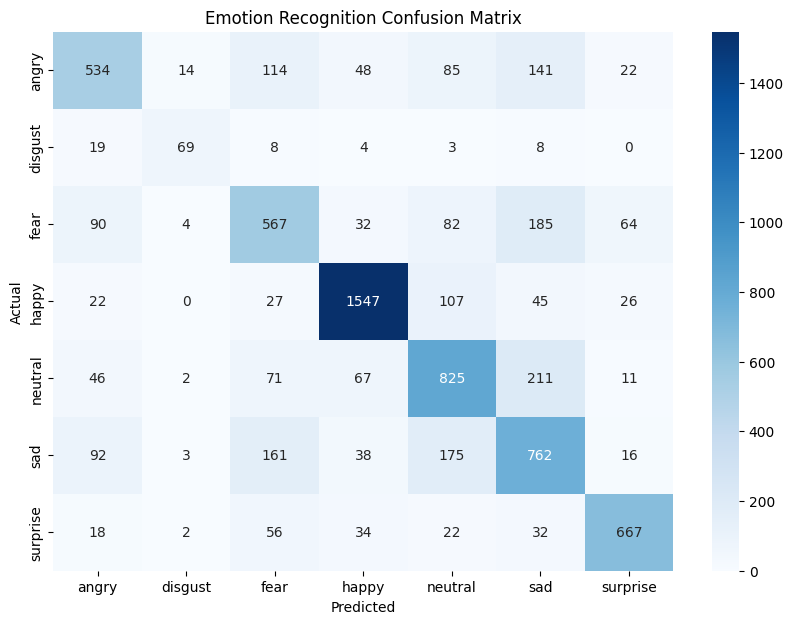

In [7]:
emotion_labels = train_dataset.classes

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Emotion Recognition Confusion Matrix")
plt.show()


# **# ✅ SECTION 8 — MULTIPLE IMAGE PREDICTION + DISPLAY**

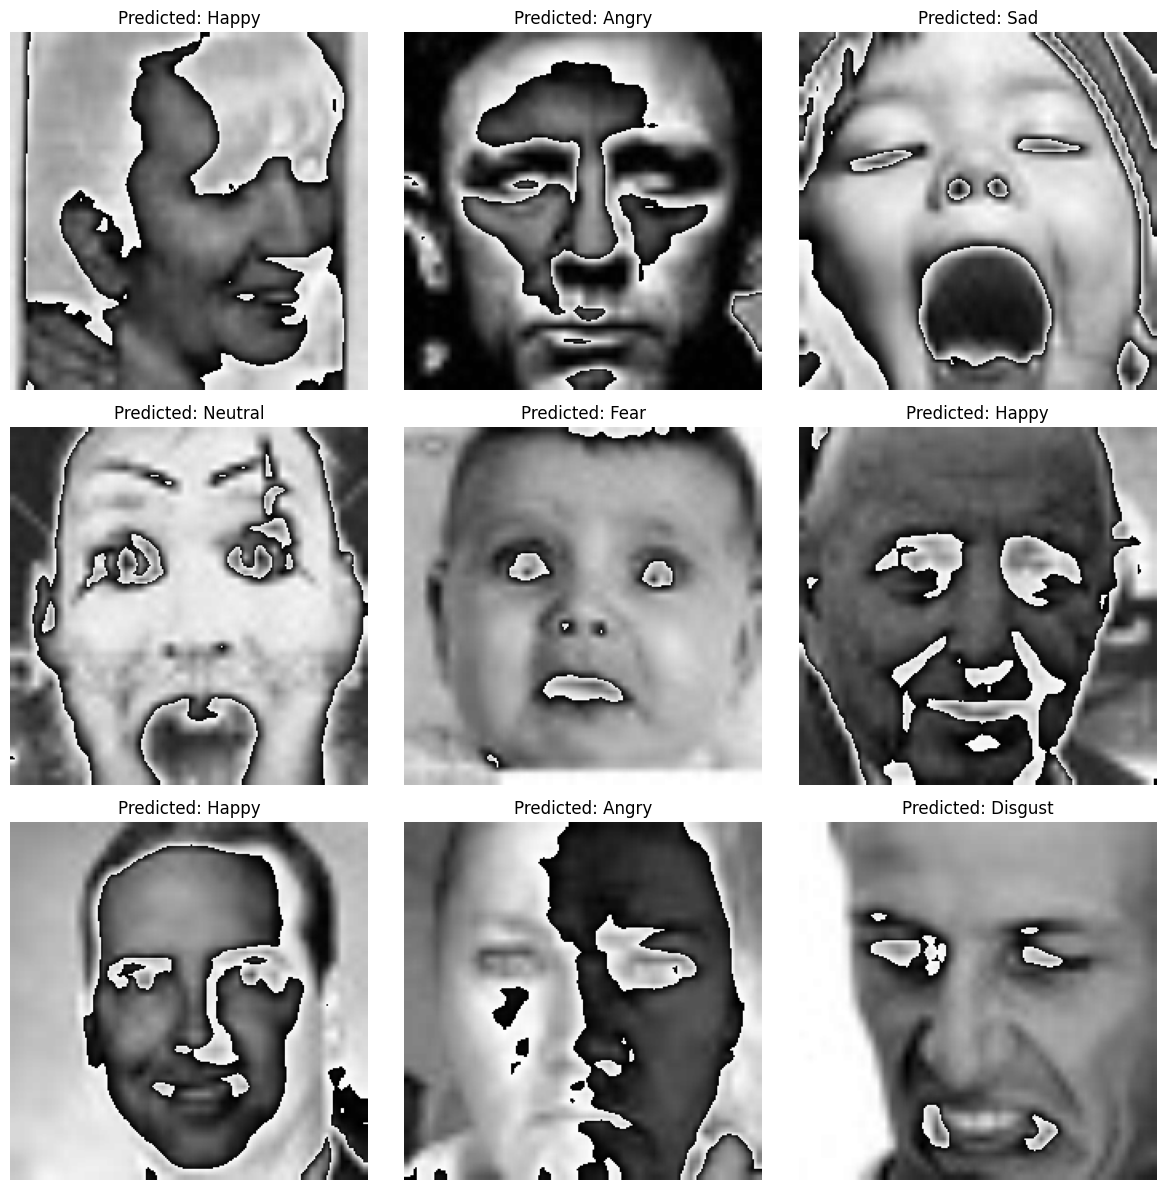

In [8]:
# Emotion label names used in dataset
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

def show_predictions(model, dataset, num_images=9):
    """
    Displays multiple test images with predicted emotion labels.
    """
    model.eval()
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        index = random.randint(0, len(dataset) - 1)
        img, true_label = dataset[index]

        # Move image to device
        image_tensor = img.unsqueeze(0).to(device)

        # Get model prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            _, pred = torch.max(outputs, 1)

        pred_label = emotion_labels[pred.item()]

        # Convert tensor → image for display
        img_display = to_pil_image(img)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img_display, cmap="gray")
        plt.title(f"Predicted: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run the function to show predictions on test dataset
show_predictions(model, test_dataset, num_images=9)


In [11]:
import torch
from torchvision import models

# Load model
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load("emotion_resnet18_weights.pth", map_location="cpu"))
model.eval()

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    model,
    {torch.nn.Linear},
    dtype=torch.qint8
)

# Save quantized model
torch.save(quantized_model.state_dict(), "emotion_resnet18_int8.pth")


/tmp/ipython-input-853700670.py:11: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(
